In [34]:
import cv2
import numpy as np
import glymur
from matplotlib import pyplot as plt

In [6]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [81]:
def ecdf(x):
    """convenience function for computing the empirical CDF"""
    vals, counts = np.unique(x, return_counts=True)
    ecdf = np.cumsum(counts).astype(np.float64)
    ecdf /= ecdf[-1]
    return vals, ecdf

In [82]:
def DrawCDF(source,template,matched,channel):
    """Draw the histogram cdf at specific channel for three images"""
    
    x1, y1 = ecdf(source[:,:,channel].ravel())
    x2, y2 = ecdf(template[:,:,channel].ravel())
    x3, y3 = ecdf(matched[:,:,channel].ravel())

    
    fig = plt.figure()
    gs = plt.GridSpec(1, 1)
    ax4 = fig.add_subplot(gs[0, 0])

    ax4.plot(x1, y1 * 100, '-r', lw=3, label='Source')
    ax4.plot(x2, y2 * 100, '-k', lw=3, label='Template')
    ax4.plot(x3, y3 * 100, '--r', lw=3, label='Matched')
    ax4.set_xlim(x1[0], x1[-1])
    ax4.set_xlabel('Pixel value')
    ax4.set_ylabel('Cumulative %')
    ax4.legend(loc=5)
    
    plt.show()

In [83]:
#test using 8 bits
FileB='/home/xli/testImages/F70-8.jp2'
FileD='/home/xli/testImages/F71-8.jp2'

template=cv2.imread(FileB).astype('uint8') #F70 is birght, hence the template
source=cv2.imread(FileD).astype('uint8')   #F71 is dark, hence the source

template=template[0:21000,0:29000,:]
source=source[0:21000,0:29000,:]

In [84]:
# Match whole image all together:
matched = hist_match(source,template)

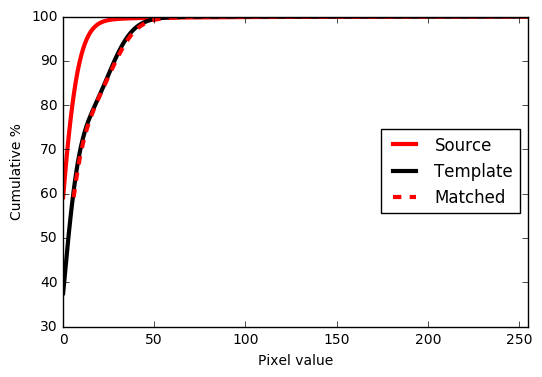

In [85]:
DrawCDF(source,template,matched,1)

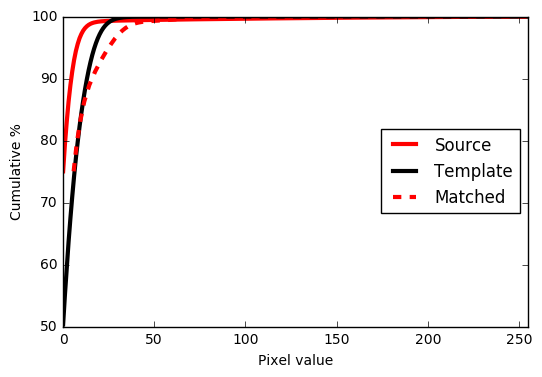

In [86]:
DrawCDF(source,template,matched,0)

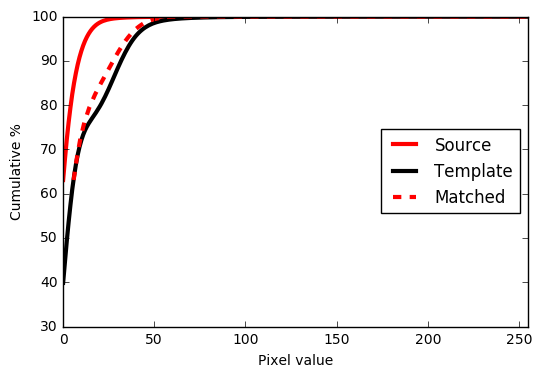

In [87]:
DrawCDF(source,template,matched,2)

In [89]:
#Match individual, then merge:
b_source=source[:,:,0]
g_source=source[:,:,1]
r_source=source[:,:,2]

b_template=template[:,:,0]
g_template=template[:,:,1]
r_template=template[:,:,2]

In [90]:
b_matched=hist_match(b_source,b_template)
g_matched=hist_match(g_source,g_template)
r_matched=hist_match(r_source,r_template)

In [92]:
matched=cv2.merge([b_matched,g_matched,r_matched])

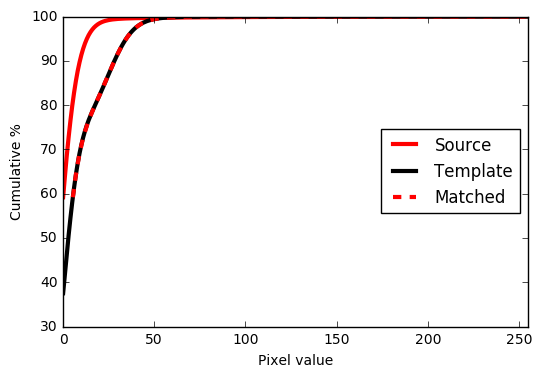

In [95]:
DrawCDF(source,template,matched,1)

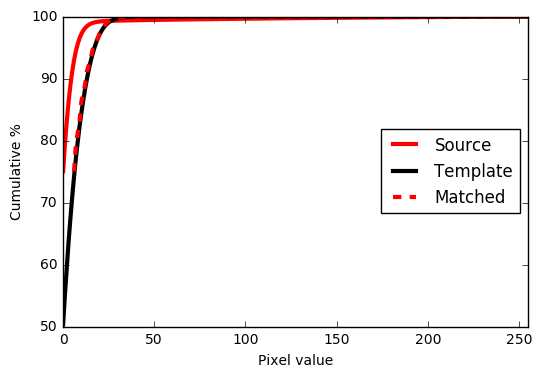

In [98]:
DrawCDF(source,template,matched,0)

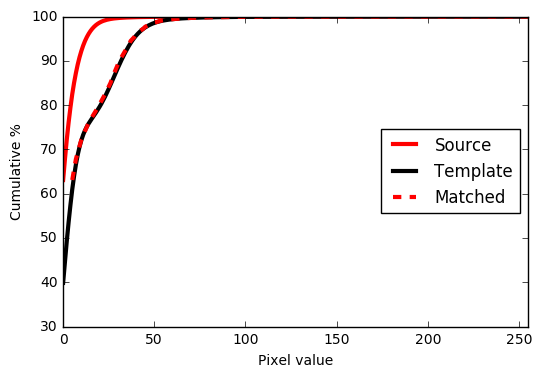

In [99]:
DrawCDF(source,template,matched,2)

In [96]:
matched=np.asarray(matched,'uint8')

In [101]:
cv2.imwrite('indiv.tif',matched)

True